This code is just an exercise to see how a cGAN can behave in the image segmentation task. It is concluded that GANs do not perform well in this task as the GAN is trained to be convincing rather than accurate, this because the discriminator looks for convincing pictures and do not care about how accurate is the segmentation.

This work borrows code from the official TensorFlow guide.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Root path
PATH = "/content/drive/My Drive/Term_Paper"

# Input path
INPATH = PATH + "/VOC_DATA/voc_input"

# Target path
OUPATH = PATH + "/VOC_DATA/voc_target"

# Checkpoints path
CKPATH = PATH + "/CHECKPOINT"

image_list = !ls -1 "{INPATH}"

# Number of images to work with.
n = 2880 
train_n = round(n * 0.80)

# Random lists
rand_list = np.copy(image_list)
np.random.shuffle(rand_list)

# Train/test split
train_split = rand_list[:train_n]
test_split = rand_list[train_n:n]

print(len(image_list), len(train_split), len(test_split))

2913 2304 576


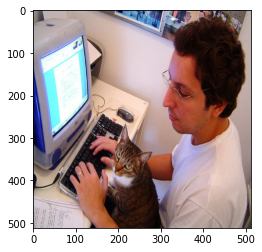

In [ ]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

# Scalling Images
def resize(input_img, target_img, height, width):
  
  input_img = tf.image.resize(input_img, [height, width])
  target_img = tf.image.resize(target_img, [height, width])
  
  return input_img, target_img

# Normalizing images [ -1, +1].
def normalize(input_img, target_img):
  input_img = (input_img / 127.5) - 1
  target_img = (target_img / 127.5) - 1
  
  return input_img, target_img

# Data Augmentation: Random Crop + Flip
def random_jitter(input_img, target_img):
  
  input_img, target_img = resize(input_img, target_img, 640, 640)
  
  stacked_image = tf.stack([input_img, target_img], axis = 0)
  cropped_image = tf.image.random_crop(stacked_image, size = [2,  IMG_HEIGHT, IMG_WIDTH, 3] )
  
  input_img, target_img = cropped_image[0], cropped_image[1]
  
  if tf.random.uniform(()) > 0.5:
    
    input_img = tf.image.flip_left_right(input_img)
    target_img = tf.image.flip_left_right(target_img)
    
  return input_img, target_img

# Image Loading
def load_image(filename, augment = True):
  
  input_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)
  target_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)), tf.float32)

  input_img, target_img = resize(input_img, target_img, IMG_HEIGHT, IMG_WIDTH)
  
  if augment:
    input_img, target_img = random_jitter(input_img, target_img)
    
  input_img, target_img = normalize(input_img, target_img)
  
  return input_img, target_img


def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)


# Loading testing [0,1] 
plt.imshow((load_test_image(rand_list[5])[0]+1)/2)



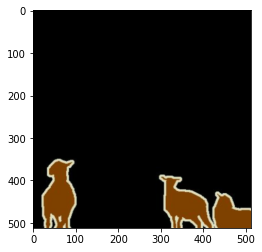

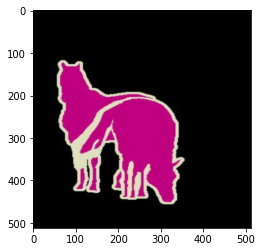

In [ ]:
# Creating datasets

train_dataset = tf.data.Dataset.from_tensor_slices(train_split)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(test_split)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

for input_img, target_img in train_dataset.take(2):
    plt.imshow((target_img[0,...]+1)/2)
    plt.show()

In [ ]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm = True):
  
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  # Conv layer.
  result.add(Conv2D(filters,
                    kernel_initializer = initializer,
                    kernel_size = 4,
                    strides = 2,
                    padding = "same",
                    use_bias = not apply_batchnorm))
  
  if apply_batchnorm:
    # BatchNorm
    result.add(BatchNormalization())
  
  # Activación.
  result.add(LeakyReLU())
  
  return result

downsample(64)

In [ ]:
def upsample(filters, apply_dropout = False):
  
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  # Conv Layer (up_sampling).
  result.add(Conv2DTranspose(filters,
                             kernel_initializer = initializer,
                             kernel_size = 4,
                             strides = 2,
                             padding = "same",
                             use_bias = False))
  

  # BatchNorm
  result.add(BatchNormalization())
  
  if apply_dropout:
    # Dropout
    result.add(Dropout(0.5))
    
  # Activación.
  result.add(ReLU())
  
  return result

upsample(64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


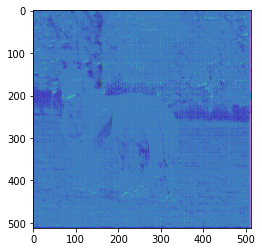

In [ ]:
def Generator():
  
  inputs = tf.keras.layers.Input(shape = [None, None, 3])
  
  down_stack = [
      downsample(64, apply_batchnorm = False), # (bs, 512, 256, 64 )
      downsample(128),                        # (bs, 256, 128, 128 )
      downsample(256),                        # (bs, 128, 64, 256 )
      downsample(512),                        # (bs, 64, 32, 512 )
      downsample(512),                        # (bs, 32, 16, 512 )
      downsample(512),                        # (bs, 16, 8, 512 )
      downsample(512),                        # (bs, 8, 4, 512 )
      downsample(512),                        # (bs, 4, 2, 512 )
  ]
  
  up_stack = [
      upsample(512, apply_dropout = True),    # (bs, 8, 4, 1024 )
      upsample(512, apply_dropout = True),    # (bs, 16, 8, 1024 )
      upsample(512, apply_dropout = True),    # (bs, 32, 16, 1024 )
      upsample(512),                          # (bs, 64, 32, 1024 )
      upsample(256),                          # (bs, 128, 64, 512 )
      upsample(128),                          # (bs, 256, 128, 256 )
      upsample(64),                           # (bs, 512, 256, 128 )
  ]
  
  initializer = tf.random_normal_initializer(0, 0.02)

  last = Conv2DTranspose(filters= 3,
                         kernel_size = 4,
                         strides = 2,
                         padding = "same",
                         kernel_initializer = initializer,
                         activation = "tanh")
  
  x = inputs
  s = []
  
  concat = Concatenate()
  
  for down in down_stack:
    x = down(x)
    s.append(x)
    
  s = reversed(s[:-1])
  
  for up, sk in zip(up_stack, s):
    
    x = up(x)
    x = concat([x, sk])
    
  last = last(x)
  
  return Model(inputs = inputs, outputs = last)

generator = Generator()
gen_output = generator(((input_img+1)*255), training = False)
plt.imshow(gen_output[0,...])

TensorShape([1, 32, 32, 1])

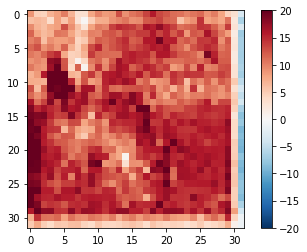

In [ ]:
def Discriminator():
  
  ini = Input(shape = [None,None,3])
  gen = Input(shape = [None,None,3])
  
  con =concatenate([ini,gen])
  
  initializer = tf.random_normal_initializer(0,0.02)
  
  down1 = downsample(64, apply_batchnorm = False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)
  
  last = tf.keras.layers.Conv2D(filters = 1,
                                kernel_size = 4,
                                strides = 1,
                                kernel_initializer = initializer,
                                padding = "same")(down4)
  
  return tf.keras.Model(inputs = [ini,gen], outputs = last)

discriminator = Discriminator()

disc_out = discriminator([(input_img+1)*255, gen_output], training = False)
plt.imshow(disc_out[0,...,-1], vmin = -20, vmax = 20, cmap = 'RdBu_r')
plt.colorbar()
disc_out.shape

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  
  # Difference between real positive and discriminator positive
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  # Difference between real false and discriminator false
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss

In [ ]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  #mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  
  return total_gen_loss

In [ ]:
'''import os

checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)
                                    
checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()'''

'import os\n\ncheckpoint_prefix = os.path.join(CKPATH, "ckpt")\ncheckpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,\n                                 discriminator_optimizer = discriminator_optimizer,\n                                 generator = generator,\n                                 discriminator = discriminator)\n                                    \ncheckpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()'

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [ ]:
def generate_images(model, test_input, tar, save_filename = False, display_imgs = True):

  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/OUTPUT/' + save_filename + '.jpg', prediction[0,...])
  
  plt.figure(figsize=(15,30))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
  plt.show()


In [ ]:
@tf.function()

def train_step(input_image, target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    
    output_image = generator(input_image, training = True)

    output_gen_discr = discriminator([output_image, input_image], training = True)

    output_trg_discr = discriminator([target, input_image], training = True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_image, target)
  
  
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [ ]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    
    imgi = 0
    for input_image, target in dataset:
      print('epoch' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(train_split)))
      imgi += 1
      train_step(input_image, target)
      
    clear_output(wait = True)
    
    imgi = 0
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs = True)
      imgi +=1
    # saving (checkpoint) the model every 30 epochs
    
    if (epoch + 1) % 500 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

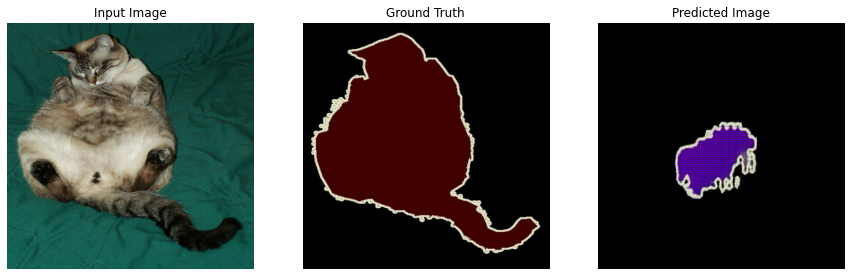

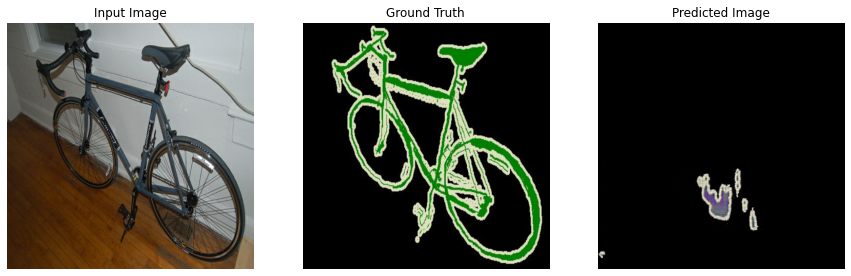

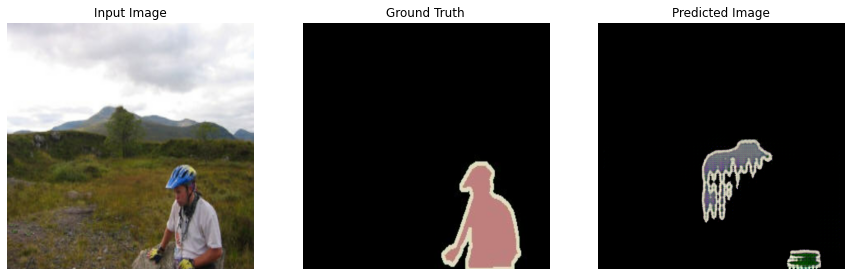

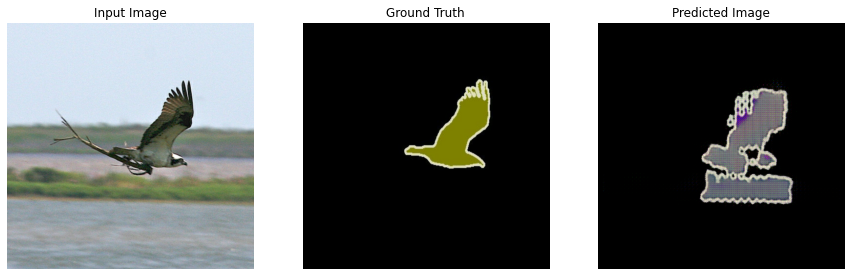

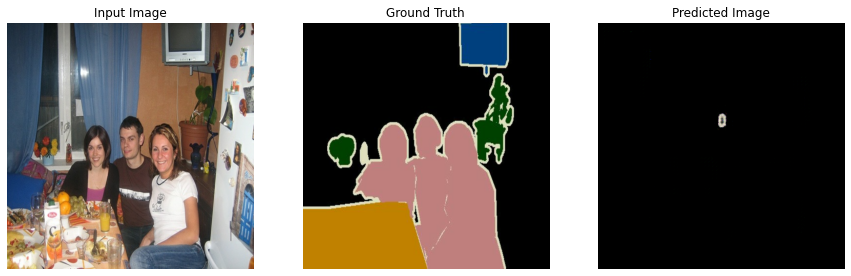

epoch117 - train: 0/2304
epoch117 - train: 1/2304
epoch117 - train: 2/2304
epoch117 - train: 3/2304
epoch117 - train: 4/2304
epoch117 - train: 5/2304
epoch117 - train: 6/2304
epoch117 - train: 7/2304
epoch117 - train: 8/2304
epoch117 - train: 9/2304
epoch117 - train: 10/2304
epoch117 - train: 11/2304
epoch117 - train: 12/2304
epoch117 - train: 13/2304
epoch117 - train: 14/2304
epoch117 - train: 15/2304
epoch117 - train: 16/2304
epoch117 - train: 17/2304
epoch117 - train: 18/2304
epoch117 - train: 19/2304
epoch117 - train: 20/2304
epoch117 - train: 21/2304
epoch117 - train: 22/2304
epoch117 - train: 23/2304
epoch117 - train: 24/2304
epoch117 - train: 25/2304
epoch117 - train: 26/2304
epoch117 - train: 27/2304
epoch117 - train: 28/2304
epoch117 - train: 29/2304
epoch117 - train: 30/2304
epoch117 - train: 31/2304
epoch117 - train: 32/2304
epoch117 - train: 33/2304
epoch117 - train: 34/2304
epoch117 - train: 35/2304
epoch117 - train: 36/2304
epoch117 - train: 37/2304
epoch117 - train: 38/2

KeyboardInterrupt: ignored

In [ ]:
train(train_dataset, 200)